In [1]:
import awswrangler as wr

import mlflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import mlflow
from mlflow.tracking import MlflowClient

from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline

In [2]:


# Para que funciones, todos nuestros scripts debemos exportar las siguientes variables de entorno
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000


env: AWS_ACCESS_KEY_ID=minio
env: AWS_SECRET_ACCESS_KEY=minio123
env: MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
env: AWS_ENDPOINT_URL_S3=http://localhost:9000


In [3]:
mlflow_server = "http://localhost:5000"


mlflow.set_tracking_uri(mlflow_server)

In [4]:
df_total = wr.s3.read_parquet("s3://data/raw/df_total.parquet")
df_total.head()

,unnamed:_0,id,gender,customer_type,age,type_of_travel,class_cus,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,...,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
# Cargamos los datos para realizar nuestro estudio.
# OBS, no vamos a cargar los datos de testing, nada de Data leakage por aquí

df_train =  wr.s3.read_csv("s3://data/clean/df_train_clean.csv")
df_test =  wr.s3.read_csv("s3://data/clean/df_test_clean.csv")

X_train = df_train.drop(['target'],axis=1)
y_train = df_train[['target']]

X_test= df_test.drop(['target'],axis=1)
y_test = df_test[['target']]

In [6]:
df_train.head()

,age,class_cus,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,...,departure_delay_in_minutes,arrival_delay_in_minutes,target,gender_male,customer_type_disloyal_customer,type_of_travel_personal_travel,inflight_wifi_service_rta0,departure_arrival_time_convenient_rta0,ease_of_online_booking_rta0,online_boarding_rta0
0,64,3,965,3,5,3,3,5,5,5,...,11,4.0,0,0,0,1,0,0,0,0
1,26,3,592,2,1,1,2,3,1,3,...,77,78.0,0,1,1,0,0,0,0,0
2,8,0,993,3,4,3,1,4,3,4,...,0,0.0,0,0,0,1,0,0,0,0
3,41,3,2223,4,4,4,4,1,2,4,...,9,4.0,1,1,0,0,0,0,0,0
4,19,0,1235,4,4,4,4,3,4,3,...,0,0.0,0,0,1,0,0,0,0,0


In [7]:
mlflow.set_tracking_uri('http://localhost:5000')

experiment_name = "customer_satisfaction_model_experiment"

if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name)

experiment = mlflow.get_experiment_by_name(experiment_name)

In [8]:
experiment

<Experiment: artifact_location='s3://mlflow/1', creation_time=1729016282600, experiment_id='1', last_update_time=1729016282600, lifecycle_stage='active', name='customer_satisfaction_model_experiment', tags={}>

In [9]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [10]:
# Creemos el experimento
experiment_id = get_or_create_experiment("customer_satisfaction_model_experiment")
print(experiment_id)

run_name_parent = "best_hyperparam"

1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     103904 non-null  int64  
 1   class_cus                               103904 non-null  int64  
 2   flight_distance                         103904 non-null  int64  
 3   inflight_wifi_service                   103904 non-null  int64  
 4   departure_arrival_time_convenient       103904 non-null  int64  
 5   ease_of_online_booking                  103904 non-null  int64  
 6   gate_location                           103904 non-null  int64  
 7   food_and_drink                          103904 non-null  int64  
 8   online_boarding                         103904 non-null  int64  
 9   seat_comfort                            103904 non-null  int64  
 10  inflight_entertainment                  1039

2024/10/17 13:26:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'customer_satisfaction_model_dev' already exists. Creating a new version of this model...
2024/10/17 13:26:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer_satisfaction_model_dev, version 2
Created version '2' of model 'customer_satisfaction_model_dev'.
2024/10/17 13:26:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run incongruous-hog-913 at: http://localhost:5000/#/experiments/1/runs/cab521314ce34ccf8ee9990876681594.
2024/10/17 13:26:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


Finalizado


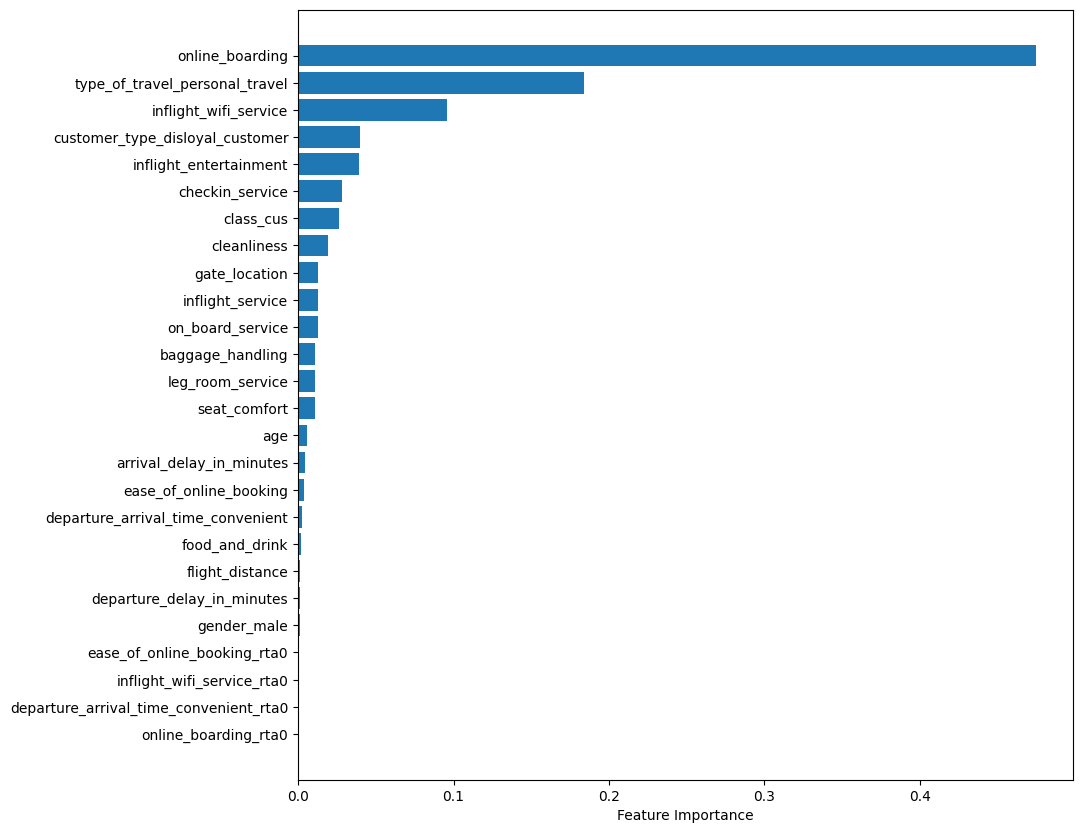

In [11]:


best_xgb_grid = xgb.XGBClassifier(**{'reg_alpha': 0.0,
 'n_estimators': 6,
 'max_depth': 9,
 'learning_rate': 0.6000000000000002,
 'colsample_bytree': 1.0})

print(X_train.info())
best_xgb_grid.fit(X_train, y_train)

artifact_path='xgb_model'
model_uri = ""
model_version = 1

with mlflow.start_run(experiment_id = experiment.experiment_id):
    # Se registran los mejores hiperparámetros
    mlflow.log_params(best_xgb_grid.get_params())
    
    # Se obtiene las predicciones del dataset de evaluación
    y_pred = best_xgb_grid.predict(X_test)
    # y_test_inversed = scaler_y.inverse_transform(y_test)
    # y_pred_inversed = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    
    # Se calculan las métricas
    auc_score_train = roc_auc_score(y_train,best_xgb_grid.predict_proba(X_train)[:, 1])
    print(f'ROC AUC TRAIN: {auc_score_train}')
    auc_score = roc_auc_score(y_test, best_xgb_grid.predict_proba(X_test)[:, 1])
    print(f'ROC AUC TEST: {auc_score}')
    accuracy = accuracy_score(y_test, best_xgb_grid.predict(X_test))
    print(f'ACCURACY: {accuracy}')
    
    # Y las enviamos a MLFlow
    metrics ={
        'ROC': auc_score,
        'Accuracy': accuracy
        }
    
    mlflow.log_metrics(metrics)
    # Obtenemos la importancia de características
    feature_importances = best_xgb_grid.feature_importances_
    feature_names = X_train.columns  # Excluir la columna objetivo

    # Ordenamos los índices
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, 10))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')

    # Guardar el gráfico en un archivo temporal
    plot_filename = 'feature_importances.png'
    plt.savefig(plot_filename)

    # Registrar el gráfico en MLflow
    mlflow.log_figure(plt.gcf(), artifact_file="feature_importances.png")


    # Registramos el modelo y los datos de entrenamiento
    mlflow.sklearn.log_model(
            sk_model=best_xgb_grid,
            artifact_path=artifact_path,
            serialization_format='cloudpickle',
            registered_model_name="customer_satisfaction_model_dev",
            metadata={"model_data_version": model_version}
            )

   
    # Obtenemos la ubicación del modelo guardado en MLFlow
    model_uri = mlflow.get_artifact_uri(artifact_path)


print('Finalizado')

In [12]:

client = MlflowClient()
name = "customer_satisfaction_model_prod"
desc = "Predict customer satisfaction"

# Creamos el modelo productivo
# Chequear si el modelo ya está registrado
registered_models = client.search_registered_models(f"name='{name}'")

if not registered_models:
    client.create_registered_model(name=name, description=desc)



# Guardamos como tag los hiper-parametros en la version del modelo
tags = best_xgb_grid.get_params()
tags["model"] = type(best_xgb_grid).__name__
tags["ROC"] = auc_score
tags["Accuracy"] = accuracy

# Guardamos la version del modelo
result = client.create_model_version(
    name=name,
    source=model_uri,
    run_id=model_uri.split("/")[-3],
    tags=tags
)

# Y creamos como la version con el alias de prod para poder levantarlo en nuestro
# proceso de servicio del modelo on-line.
client.set_registered_model_alias(name, "prod", result.version)

2024/10/17 13:26:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer_satisfaction_model_prod, version 2


In [13]:
loaded = mlflow.sklearn.load_model("models:/customer_satisfaction_model_prod/1" )

c:\Users\aestu\anaconda3\envs\ADM2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
test_data = df_test.head(1).drop(['target'],axis=1)
loaded.predict(np.array(test_data).reshape([1, -1]))

array([0])